# Time Series Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [42]:
df = pd.read_csv('processed_df.csv')
df.timedelta = pd.to_timedelta(df.timedelta)
print (df.shape)
df.head(2)

(139872, 21)


,timedelta,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,...,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace,by_gse_std,bz_gse_std,bt_std,density_std,speed_std
0,00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,...,-7,65.400000,1.522377e+06,143704.600000,149496.700000,1.224754,0.580028,1.607043,0.479647,15.025364
1,01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,...,-10,65.421154,1.522503e+06,143388.108333,149560.758333,0.907098,0.731278,0.325293,0.698365,17.203299


In [52]:
dfa = df[df.period=='train_a'][:3000]
dfa.drop(['period'], axis=1, inplace=True)
print (dfa.shape)
dfa.head(2)

(3000, 20)


,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace,by_gse_std,bz_gse_std,bt_std,density_std,speed_std
0,00:00:00,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000,1.224754,0.580028,1.607043,0.479647,15.025364
1,01:00:00,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333,0.907098,0.731278,0.325293,0.698365,17.203299


# Prediction : Univariate case.


**Naive Method**: Last point of the train data would be predicted as the future no matter how far you want to predict. The naive method has the following forecast algorithm,

$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = y_{T_\text{train}},
$$

**Average Method**: Take average of your train date and predict the average for your test date. The average method forecasts looks like following:

$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = \frac{1}{T_\text{train}}\sum_{t=1}^{T_\text{train}} y_t.
$$

In [53]:
dfa_train = dfa[:2500]
dfa_test  = dfa.drop(dfa_train.index)
print (dfa_train.shape, dfa_test.shape)
dfa_train.head(2)

(2500, 20) (500, 20)


,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace,by_gse_std,bz_gse_std,bt_std,density_std,speed_std
0,00:00:00,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000,1.224754,0.580028,1.607043,0.479647,15.025364
1,01:00:00,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333,0.907098,0.731278,0.325293,0.698365,17.203299


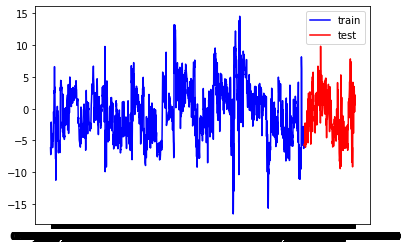

In [5]:
def plot_feature(df_train, df_test, feature):
    plt.plot(df_train.timedelta, df_train[feature], color='blue', label='train')
    plt.plot(df_test.timedelta,  df_test[feature],  color='red',  label='test')
    plt.legend()

plot_feature(dfa_train, dfa_test,  'bx_gse')

In [6]:
def plot_prediction(df_train, df_test, feature, naive=True):
    if naive:
        # Naive Method
        bx_pred = df_train[feature].values[-1] * np.ones(len(df_test[feature]))
        plt.title('The Naive method', color='maroon', fontsize=16)
    else:
        # Average Method
        bx_pred = np.mean(df_train[feature]) * np.ones(len(df_test[feature]))
        plt.title('The Average method', color='maroon', fontsize=16)
    
    plt.plot(df_train.timedelta, df_train[feature], color='blue', label='train data')
    plt.plot(df_test.timedelta,  df_test[feature],  color='red',  label='test data')
    plt.plot(df_test.timedelta,  bx_pred,           color='maroon',  label='predictions')
    plt.legend()

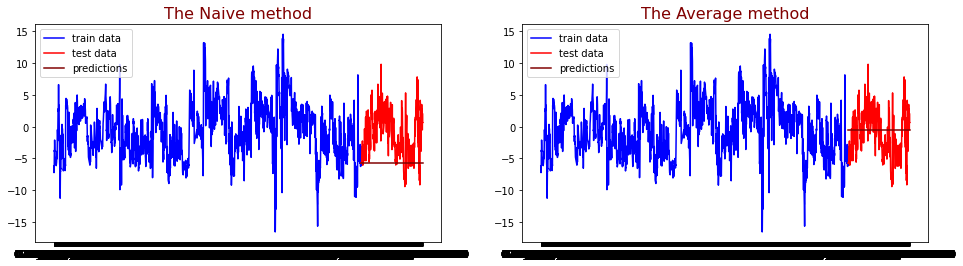

In [7]:
# First the Naive and Average method
plt.figure(figsize=(16,4))
plt.subplot(121)
plot_prediction(dfa_train, dfa_test, feature='bx_gse', naive=True)
plt.subplot(122)
plot_prediction(dfa_train, dfa_test, feature='bx_gse', naive=False)

## Lag, Autocorrelation and Seasonality

In [8]:
# This function makes a lag_df
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

# A function to make our plotting easier
def plot_lag(df,feature,lag):
    df = make_lag_df(df,feature,lag).dropna()
    plt.scatter(df[feature+'_lag'],df[feature])
    
    xx=np.linspace(df[feature+'_lag'].min(), df[feature+'_lag'].max(), 10)
    plt.plot(xx, xx, 'k--', alpha = .6)
    
def plot_lag_all(df, feature, Nlag=8):
    plt.figure(1, figsize=(20,Nlag))

    for i in range(Nlag):
        plt.subplot(Nlag//4,4,1+i)
        plot_lag(df,feature, i)
        plt.title('lag='+str(i))
    plt.show()

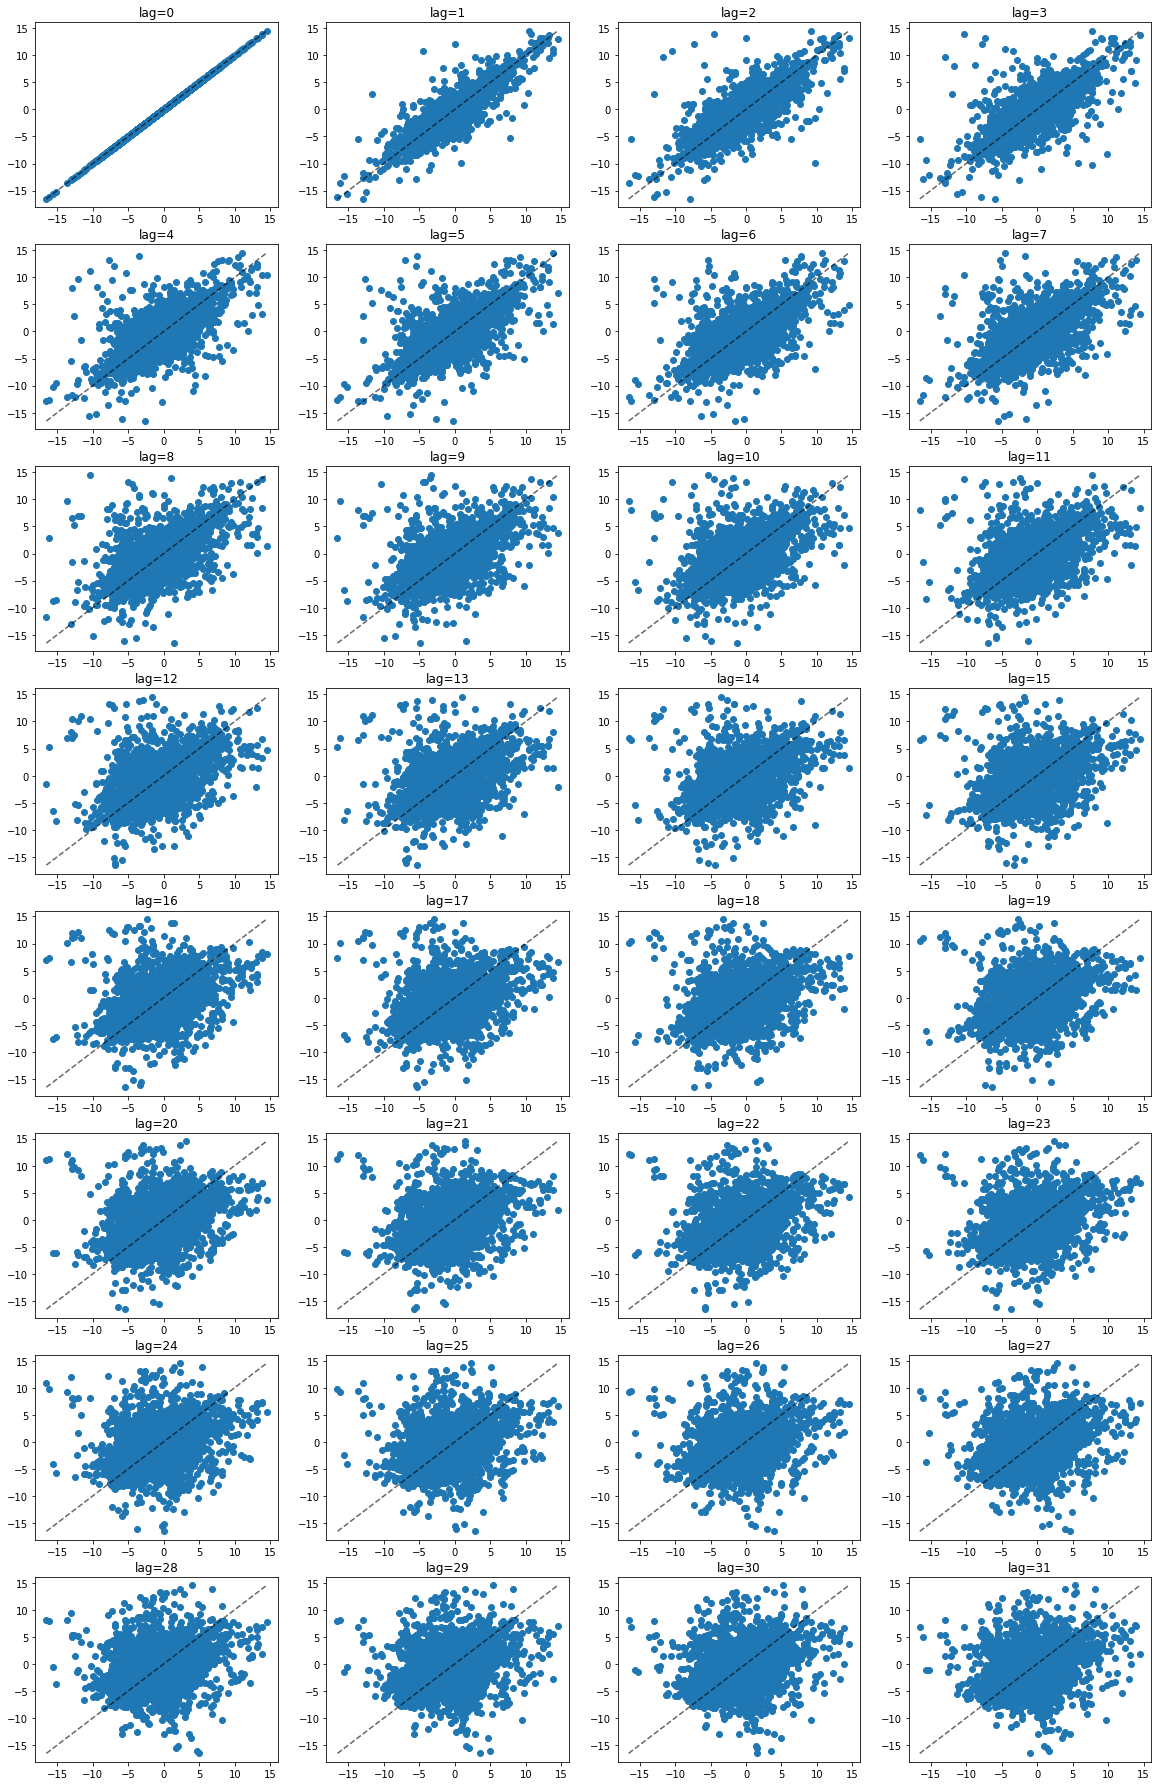

In [9]:
plot_lag_all(dfa_train, 'bx_gse', Nlag=32)

- I wanted to see if there is any seasonlity on the plot which could be seen by these lag plots. But there seems to be no seasonality seeing this plot.
- Even after plotting for 64 days it seems not be that straight of a line.
- The second and third plot (lag =1 and 2) seem a bit correlated as it makes sense for a next day or next 2nd day.

**Let's look at the same thing for `dst` data**


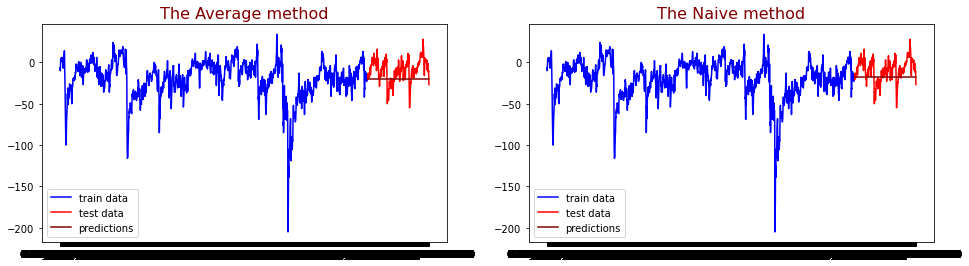

In [10]:
# First the Naive and Average method
plt.figure(figsize=(16,4))
plt.subplot(121)
plot_prediction(dfa_train, dfa_test, feature='dst', naive=False)
plt.subplot(122)
plot_prediction(dfa_train, dfa_test, feature='dst', naive=True)

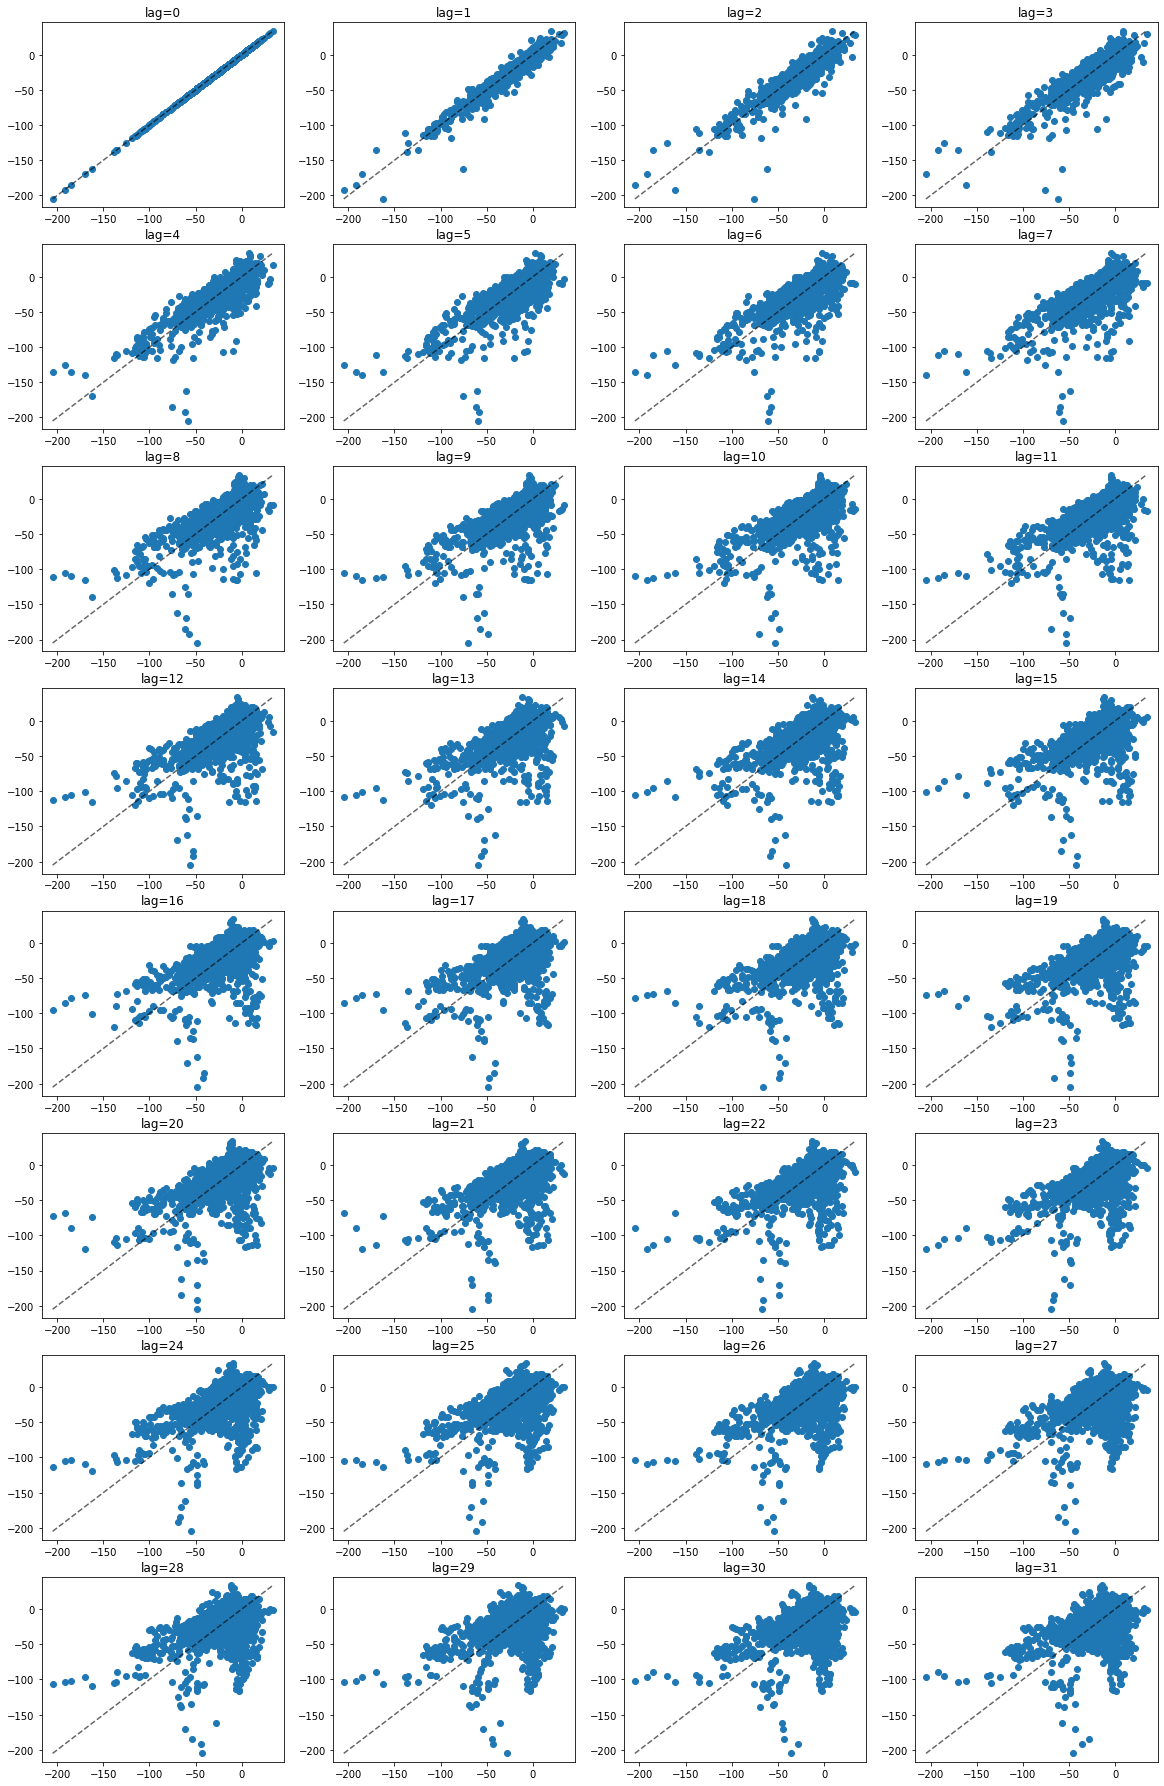

In [11]:
# lag plot
plot_lag_all(dfa_train, 'dst', Nlag=32)

### Autocorrelation 

Remember Pearson's correlation, $\rho$, measures the strength of the linear relationship between $X$ and $y$.

We can do the same thing with time series data, except this time it is called autocorrelation. We can measure the strength of the linear relationship between $y_t$ and $y_{t-k}$ with the following formula:
$$
r_k = \frac{\sum_{t = k+1}^T \left( y_t - \overline{y}  \right)  \left( y_{t-k} - \overline{y}  \right)}{\sum_{t=1}^T \left( y_t - \overline{y}  \right)^2},
$$
where $T$ is the length of the time series, and $\overline{y} = \frac{1}{T} \sum_{t=1}^T y_t$.


In [12]:
def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

In [13]:
[[i, get_autocorr(dfa_train, 'dst', i)] for i in range(1, 100, 10)]

[[1, 0.9744965727298063],
 [11, 0.667992828578849],
 [21, 0.5702423035206419],
 [31, 0.45371764380016344],
 [41, 0.37052637506056935],
 [51, 0.2914071381050181],
 [61, 0.21447308786482286],
 [71, 0.16427310582403115],
 [81, 0.08457697217885425],
 [91, 0.05071391848127186]]

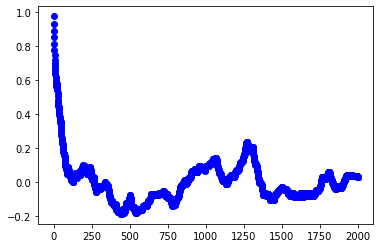

In [14]:
Nlag = 2000
plt.scatter(np.arange(1,Nlag+1,1),
            [get_autocorr(dfa_train,'dst',lag) for lag in np.arange(1,Nlag+1,1)],
            c='b')

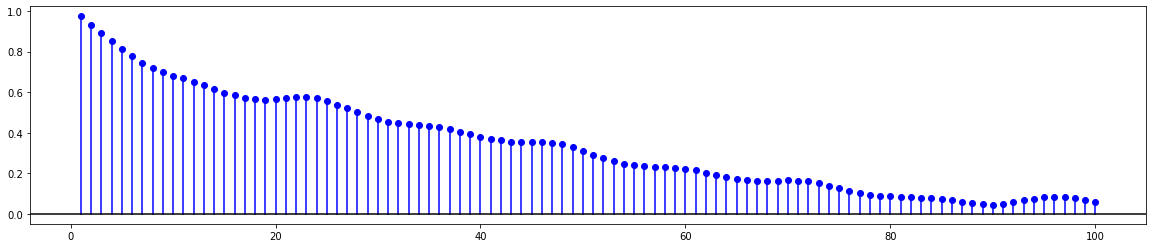

In [15]:
plt.figure(figsize=(20, 4))
Nlag = 100
ac = [get_autocorr(dfa_train,'dst',lag) for lag in np.arange(1,Nlag+1,1)]
plt.scatter(np.arange(1,Nlag+1,1), ac, c='b')

for i in np.arange(1,Nlag+1,1):
    plt.plot(i*np.ones(2), [0,get_autocorr(dfa_train,'dst',i)],'b')
plt.axhline(y=0, color='k')
    

## Exponential Smoothing 


In [16]:
# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing

In [18]:
def plot_smoothed_data(df_train, df_test, feature):
    # We make a SimpleExpSmoothing object like this
    # the data you want to train on is the input
    ses = SimpleExpSmoothing(df_train[feature].values)
    fit = ses.fit(smoothing_level=0.5, optimized=False)

    plt.figure(figsize=(20,6))
    plt.plot(df_train.timedelta, df_train[feature], color='blue', label='Training Data')
    plt.plot(df_test.timedelta, df_test[feature], 'b--', label='Test Data')
    
    plt.plot(df_train.timedelta, fit.fittedvalues , 'r-', label='Fitted Values')
    plt.plot(df_test.timedelta, fit.forecast(len(df_test)) , 'r--', label='Forecast')
    plt.legend()

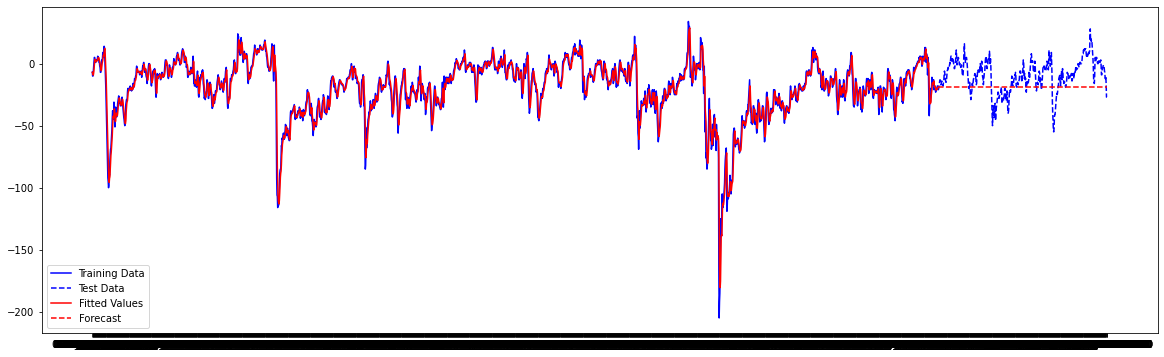

In [19]:
plot_smoothed_data(dfa_train, dfa_test, 'dst')

## AutoRegressive Integrated Moving Average (ARIMA) Models

- https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [22]:
def get_MA(df, feature, T=1):
    ma_df = df.copy()
    ma_df[feature+'_ma'] = np.nan
    for i in range(len(df[feature])-T):
        ma_df.loc[i+T, feature+'_ma'] = np.mean( df[feature].loc[i:i+T]  )
    return ma_df

def plot_MA(df, feature, T=1):
    df_ma=get_MA(df, feature, T)
    plt.plot(df.timedelta, df[feature], 'bo', label='Training data')
    plt.plot(df_ma.timedelta, df_ma[feature+'_ma'], 'g-', lw='2.', label='moving Average' )
    plt.legend()

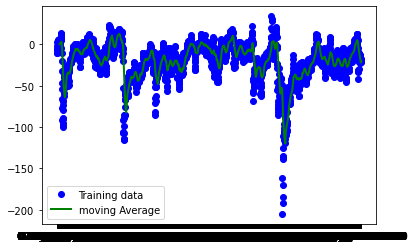

In [23]:
plot_MA(dfa_train, 'dst', T=24)

In [24]:
from statsmodels.tsa.api import ARIMA

In [25]:
def arima_fit(df_train, df_test, feature, order=(1,0,1)):
    #order as (p,d,q)
    arima = ARIMA(dfa_train.dst.values, order = order)
    arima_fit = arima.fit()

    plt.plot(df_train.timedelta, df_train[feature], 'b-', label='Training Data')
    plt.plot(df_train.timedelta, arima_fit.fittedvalues , 'r-', label='Fitted Values')
    
    
    plt.plot(df_test.timedelta, df_test[feature], 'b--', label='Test Data')
    plt.plot(df_test.timedelta, arima_fit.forecast(len(df_test.dst))[0] , 'r--', label='Forecast')
    plt.plot(df_test.timedelta, arima_fit.forecast(len(df_test.dst))[2] , 'g--', label='Confidence Interval')

    plt.legend(fontsize='large')
    
#arima_fit(dfa_train, dfa_test, 'dst')

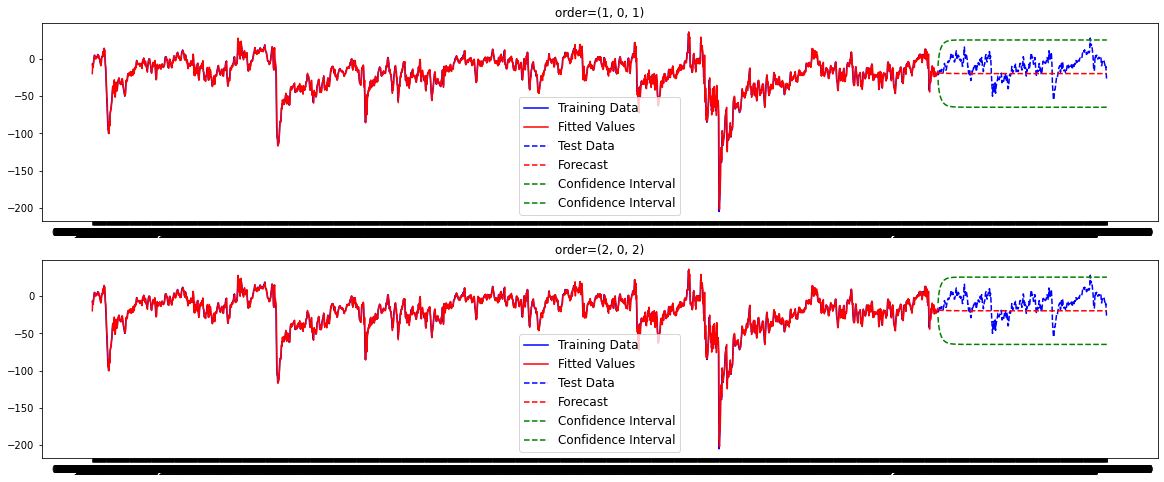

In [26]:
pdq_list = [ (1,0,1), (2, 0, 2) ]

plt.figure(figsize=(20,4*len(pdq_list)))
for i, pdq in enumerate(pdq_list):
    plt.subplot(len(pdq_list), 1, 1+i )
    plt.title('order='+str(pdq))
    arima_fit(dfa_train, dfa_test, 'dst', order=pdq)

# Vector Auto Regression (VAR)
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/


### Testing Causation using Granger’s Causality Test

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In [27]:
#from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [46]:
dfa_train.head(2)

,timedelta,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,...,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace,by_gse_std,bz_gse_std,bt_std,density_std,speed_std
0,00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,...,-7,65.400000,1.522377e+06,143704.600000,149496.700000,1.224754,0.580028,1.607043,0.479647,15.025364
1,01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,...,-10,65.421154,1.522503e+06,143388.108333,149560.758333,0.907098,0.731278,0.325293,0.698365,17.203299


In [47]:
#print (dfa_train.columns)
dfa_train = dfa_train.drop(['temperature', 'smoothed_ssn', 'gse_x_ace',
                            'gse_y_ace', 'gse_z_ace', 'by_gse_std', 'bz_gse_std',
                            'bt_std', 'density_std', 'speed_std'], axis=1)

print (dfa_train.columns)
dfa_train.head(2)

Index(['timedelta', 'period', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bt', 'density', 'speed', 'dst'],
      dtype='object')


,timedelta,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,dst
0,00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,-7
1,01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,-10


In [30]:
from statsmodels.tsa.stattools import grangercausalitytests
df = dfa_train.drop(['timedelta', 'period'], axis=1)

In [31]:
df.head(2)

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,dst
0,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,-7
1,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,-10


In [32]:
def grangers_causation_matrix(df, variables, test='ssr_chi2test', maxlag=12, verbose=False):
    dfc = pd.DataFrame(np.zeros((len(variables), len(variables))),
                       columns=variables, index=variables)
    for r in variables:
        for c in variables:
            test_res = grangercausalitytests(df[[r, c]], maxlag=12, verbose=False)
            min_p_val= np.min([ round(test_res[i+1][0][test][1], 4) for i in range(12)])
            dfc.loc[r, c] = min_p_val
    dfc.columns = [var + '_x' for var in variables]
    dfc.index = [var + '_y' for var in variables]
    return dfc

In [33]:
dfc = grangers_causation_matrix(df, variables = df.columns)
dfc

,bx_gse_x,by_gse_x,bz_gse_x,theta_gse_x,phi_gse_x,bt_x,density_x,speed_x,dst_x
bx_gse_y,1.0000,0.0000,0.0000,0.0001,0.0015,0.0000,0.1424,0.0003,0.0002
by_gse_y,0.0000,1.0000,0.2162,0.1841,0.0258,0.0000,0.0037,0.0010,0.0568
bz_gse_y,0.0000,0.0000,1.0000,0.3120,0.0002,0.0004,0.1400,0.0000,0.2915
theta_gse_y,0.0009,0.0000,0.0026,1.0000,0.0000,0.4448,0.3778,0.0597,0.3901
phi_gse_y,0.0135,0.0000,0.0302,0.0224,1.0000,0.0002,0.0523,0.0001,0.0058
bt_y,0.1045,0.0001,0.1449,0.3858,0.0471,1.0000,0.0000,0.0000,0.0001
density_y,0.8506,0.0010,0.0066,0.0469,0.0809,0.0123,1.0000,0.0040,0.0431
speed_y,0.0000,0.0778,0.0192,0.1016,0.2774,0.0000,0.1651,1.0000,0.0223
dst_y,0.0001,0.0000,0.0000,0.0000,0.0859,0.0000,0.0000,0.0000,1.0000


So how to read the above output?

The row are the Response (Y) and the columns are the predictor series (X).

For example, if you take the value 0.0015 in (row 1, column 5), it refers to the p-value of `phi_gse_x` causing `bx_gse_y`. Whereas, the 0.000 in (row 1, column 3) refers to the p-value of `bz_gse_x` causing `bx_gse_y`.

**So, how to interpret the p-values?**

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0015 at (row 1, column 5) represents the p-value of the Grangers Causality test for `phi_gse_x` causing `bx_gse_y` which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude `phi_gse_x` causes `bx_gse_y`.

**In the table above, there are a few entries with p-value > significance level (0.05). for example `p_value = 0.1449` for `bz_gse_x` `bt_y`. Not sure what to do with that. The tutorial doesn't tell anything about this. For now let's continue.**


## Differencing plot

In [ ]:
dfa = dfa_train.drop(['timedelta', 'period'], axis=1)

In [48]:
dfa_train.head(2)

,timedelta,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,dst
0,00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,-7
1,01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,-10


In [49]:
dfa_train.timedelta[1] - dfa_train.timedelta[0] 

Timedelta('0 days 01:00:00')

In [51]:
dfa_train.diff()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [50]:
def diff_plot(df_train, df_test, feature, t_diff=1):
    plt.plot(df_train.diff()['timedelta'],
             df_train.diff()[feature],
             'b', label = "Training Data")
    
    
diff_plot(dfa_train, dfa_test, 'dst')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# plot the forecast
plt.figure(figsize=(10,6))

# the training data and fitted values
plt.plot(goog_train.diff().index, goog_train.diff().closing_price,
             'b', label = "Training Data")
plt.plot(goog_train.diff().dropna().index,fit.fittedvalues,
             'r', label = "Fitted Values")

plt.xlabel("Trading Day", fontsize = 16)
plt.ylabel("Closing Price", fontsize = 16)

plt.legend(fontsize=14)
plt.show()

In [ ]:
print ( df.shape )
df.head(2)

In [ ]:
df.dtypes

In [ ]:
#https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
model = VAR(endog=df.values)
model_fit = model.fit()

In [ ]:
preds = model_fit.forecast(model_fit.y, steps=5)

In [ ]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
data = sm.datasets.macrodata.load_pandas()
data = data.data[["realgdp", "realcons"]].pct_change().dropna()

In [ ]:
data.head(2)

In [ ]:
gc_res = grangercausalitytests(data, 4)